<a href="https://colab.research.google.com/github/ARJUN108-verma/LLMs-Large-Language-Models-/blob/main/Text_Classification_with_XLNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Classification with XLNET:-

In [64]:
!pip install cleantext

In [65]:
!pip install clean

In [66]:
import pandas as pd
import numpy as np
import cleantext as clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, pipeline, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [68]:
!pip install datasets

In [69]:
!pip install evaluate

In [70]:
import datasets
import evaluate
import random

Preprocess the data:-

In [71]:
data_val = pd.read_csv("/content/emotion-labels-val.csv")
data_train = pd.read_csv("/content/emotion-labels-train.csv")
data_test = pd.read_csv("/content/emotion-labels-test.csv")

In [72]:
data_val.head()

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy


In [73]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [74]:
data_test.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [75]:
data = pd.concat([data_train, data_val, data_test], ignore_index=True)

In [76]:
import cleantext as clean

In [77]:
data['text_clean'] = data['text'].apply(lambda x: clean.clean(x, clean_all= True, extra_spaces=True))

In [78]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(r'http\S+', '', x))

In [79]:
data.head(27)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing @GaryDelaney in Burs...
1,Oh dear an evening of absolute hilarity I don'...,joy,Oh dear an evening of absolute hilarity I don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,Been waiting all week for this game ❤️❤️❤️ #ch...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,"@gardiner_love : Thank you so much, Gloria! Yo..."
4,I feel so blessed to work with the family that...,joy,I feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"Today I reached 1000 subscribers on YT!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"@Singaholic121 Good morning, love! Happy first..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#BridgetJonesBaby is the best thing I've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing @GaryDelaney in Burs...
9,@IndyMN I thought the holidays could not get a...,joy,@IndyMN I thought the holidays could not get a...


<Axes: xlabel='label'>

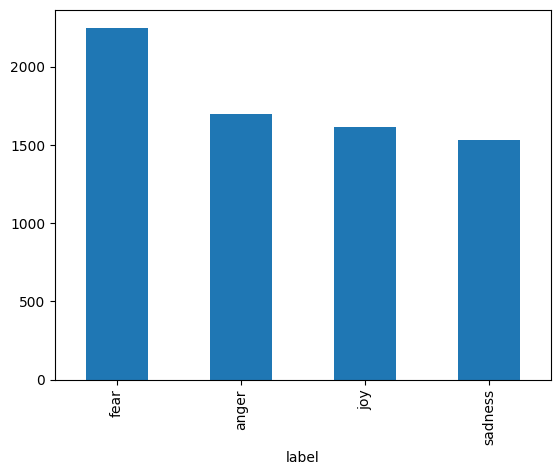

In [80]:
data['label'].value_counts().plot(kind='bar')

In [81]:
g = data.groupby('label')

In [82]:
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/tmp/ipython-input-2703046170.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

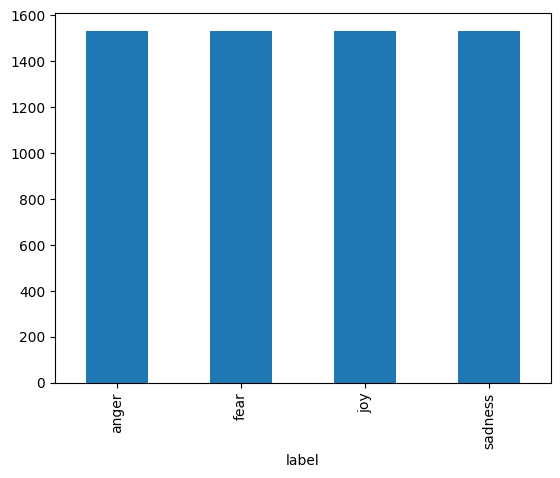

In [83]:
data['label'].value_counts().plot(kind='bar')

In [84]:
data['label'] = LabelEncoder().fit_transform(data['label'])

In [85]:
NUM_LABELS = 4

Split:-

In [86]:
train_split, test_split = train_test_split(data, test_size=0.2, random_state=42)

In [87]:
train_slit, val_split = train_test_split(train_split, train_size = 0.9)

In [88]:
print(len(train_slit))
print(len(val_split))
print(len(test_split))

4414
491
1227


In [89]:
print(train_split.columns)

Index(['text', 'label', 'text_clean'], dtype='object')


In [90]:
train_df = pd.DataFrame({
    "label": train_split["label"].values,
    "text": train_split["text_clean"].values
})

In [91]:
train_split["label_int"] = train_split["label"].astype('category').cat.codes

In [92]:
test_df = pd.DataFrame({
    "label": train_split["label_int"].values,
    "text": train_split["text_clean"].values
})


In [93]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_df.to_dict("list"))
test_dataset = Dataset.from_dict(test_df.to_dict("list"))

In [94]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [95]:
dataset_dict


DatasetDict({
    train:       label                                               text
    0         2  Shanghais chief distracting levity pampa - pro...
    1         0  @EliTheProphet_ @ChrisMellini this is an autom...
    2         1       That rocky horror remake looks a bit w a n k
    3         1  Never let your #fear decide your #future 󾍘🏽\nH...
    4         0  Nothing is more relentless than a dog begging ...
    ...     ...                                                ...
    4900      2  My ukulele bag has fallen apart. 😐 WELLL AT LE...
    4901      3  it's pretty depressing when u hit pan on ur fa...
    4902      3  At least I don't have a guy trying to discoura...
    4903      3               My life went from happy to unhappy..
    4904      0  one month til someone's bday and i think it's ...
    
    [4905 rows x 2 columns]
    test:       label                                               text
    0         2  Shanghais chief distracting levity pampa - pro...
  

Create embeddings:-

In [96]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [97]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [100]:
from datasets import Dataset, DatasetDict

In [101]:
dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

In [102]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

In [103]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4905
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4905
    })
})

In [104]:
print(tokenized_datasets['train']['text'][0])

Shanghais chief distracting levity pampa - proper dingle carry away: uUDQujcia


In [105]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4800, 23, 735, 17342, 56, 17, 10869, 769, 943, 1701, 101, 17, 13, 3122, 17, 3487, 529, 1925, 308, 60, 17, 660, 15435, 8608, 1315, 7679, 4, 3]


In [106]:
tokenizer.decode(5)

'<pad>'

In [107]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [108]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [109]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

Fine tune our model:-

In [110]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=NUM_LABELS,
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
metric = evaluate.load("accuracy")

In [112]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [113]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [114]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [115]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 164

Evaluate model:-

In [116]:
trainer.evaluate()


Error: You must call wandb.init() before wandb.log()

In [117]:
model.save_pretrained("fine_tuned_model")

In [118]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [119]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)


Device set to use cpu


In [120]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)

/tmp/ipython-input-3116462782.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
/tmp/ipython-input-3116462782.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int], top_k=None)


@MiSSLiNDZO no. 😭 the last two we were out-bidded. So we got kinda discouraged so now we are taking our sweet time. The market is stupid tho
[{'label': 'joy', 'score': 0.5125669836997986}, {'label': 'fear', 'score': 0.21676893532276154}, {'label': 'anger', 'score': 0.13818234205245972}, {'label': 'sadness', 'score': 0.13248176872730255}]
